# Element-wise reservoir contribution from input signal

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, linalg, sparse

from ddc.data import DataLorenz96

In [2]:
plt.style.use("./rc-gfd.mplstyle")

Using standard normal, IID input show how
- Variance grows linearly with normal Win and sub-linearly with uniform Win
- Show how this is mitigated with (1) 1/sqrt(Nin) and (2) largest singular value
- Show what these two factors look like as a function of Nin and Nres

In [11]:
class InputVectorCalculator():
    n_samples = 100
    n_reservoir = 500
    random_seed = 0
    input_sizes = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
    
    input_scale = 1
    
    def __init__(self, **kw):
        for key, val in kw.items():
            try:
                getattr(self, key)
            except:
                raise
                
            setattr(self, key, val)
            
        reservoir = np.arange(self.n_reservoir)
        self.reservoir = xr.DataArray(reservoir, coords={"reservoir": reservoir}, dims=("reservoir",))
        
        sample = np.arange(self.n_samples)
        self.sample = xr.DataArray(sample, coords={"sample": sample}, dims=("sample",))
        
        self.input_size = xr.DataArray(self.input_sizes, coords={"input_size": self.input_sizes}, dims=("input_size",))
        
            
    def calc_input_vector(self):
        
        rs = np.random.RandomState(self.random_seed)
        ni = len(self.input_sizes)
        nor = np.zeros(shape=(ni, self.n_samples, self.n_reservoir))
        uni = nor.copy()
        d_u = np.zeros(shape=(ni, self.n_samples))
        d_n = d_u.copy()
        
        for i, n_input in enumerate(self.input_sizes):
            
            allU = np.random.normal(scale=1,
                                    size=(self.n_samples, n_input))
            
            for j,u in enumerate(allU):
                
                Wu = rs.uniform(low=-self.input_scale, high=self.input_scale, size=(self.n_reservoir,  n_input))
                Wn = rs.normal(scale=self.input_scale, size=(self.n_reservoir, n_input))
                
                d_u[i,j] = np.max(linalg.svdvals(Wu))
                d_n[i,j] = np.max(linalg.svdvals(Wn))
                
                nor[i, j, :] = Wn @ u
                uni[i, j, :] = Wu @ u
            
            
        ds = self.pack_dataset(nor, uni, d_n, d_u)
        return ds
    
    def pack_dataset(self, nor, uni, d_n, d_u):
        ds = xr.Dataset()
        ds["reservoir"] = self.reservoir
        ds["sample"] = self.sample
        ds["input_size"] = self.input_size
        xdalike = ds.input_size * ds.sample * ds.reservoir
        ds["normal"] = xr.DataArray(nor, coords=xdalike.coords, dims=xdalike.dims, attrs={"label": "Reservoir Input from Normal Matrix"})
        ds["uniform"] = xr.DataArray(uni, coords=xdalike.coords, dims=xdalike.dims, attrs={"label": "Reservoir Input from Uniform Matrix"})
        xdalike = ds.input_size*ds.sample
        ds["d_u"] = xr.DataArray(d_u, coords=xdalike.coords, dims=xdalike.dims, attrs={"label": r"$\sigma_{max}$ from Normal Matrix"})
        ds["d_n"] = xr.DataArray(d_n, coords=xdalike.coords, dims=xdalike.dims, attrs={"label": r"$\sigma_{max}$ from Uniform Matrix"})
        return ds

In [12]:
ivc = InputVectorCalculator()

In [13]:
%%time
ds = ivc.calc_input_vector()

CPU times: user 35.5 s, sys: 195 ms, total: 35.7 s
Wall time: 6 s


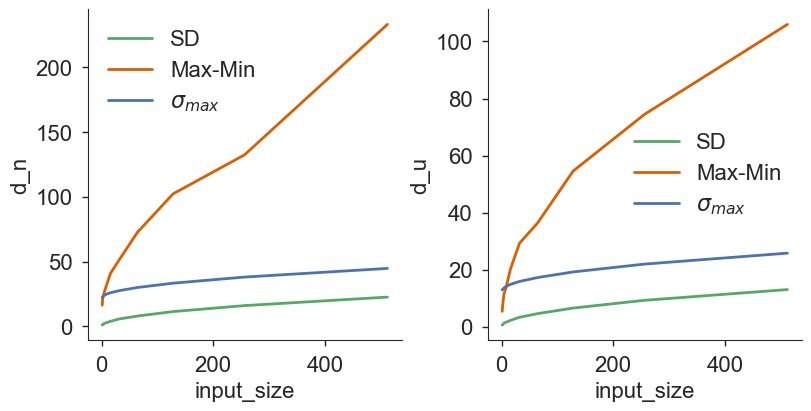

In [14]:
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

dims = ["reservoir", "sample"]
for key, ax in zip(
    ["normal", "uniform"],
    axs):
    p = ds[key].std(dims).plot(label="SD", ax=ax)
    color = p[0].get_color()
    rng = ds[key].max(dims) - ds[key].min(dims)
    rng.plot(label="Max-Min",  ax=ax)
    k = f"d_{key[0]}"
    ds[k].mean("sample").plot(label=r"$\sigma_{max}$", ax=ax)
    ax.legend()


Observe:
- Range of output is much larger than standard deviation

For lorenz example we're close to the left side of the curve, is using sigmamax better because we normalize by
max-min? is that what we should be doing?
Should we normalize the input by max-min to put the input data on the linear regime of the tanh function, then
the reservoir is what controls the nonlinearity?

standard deviation normalizes 68% of the data points... is this not enough?

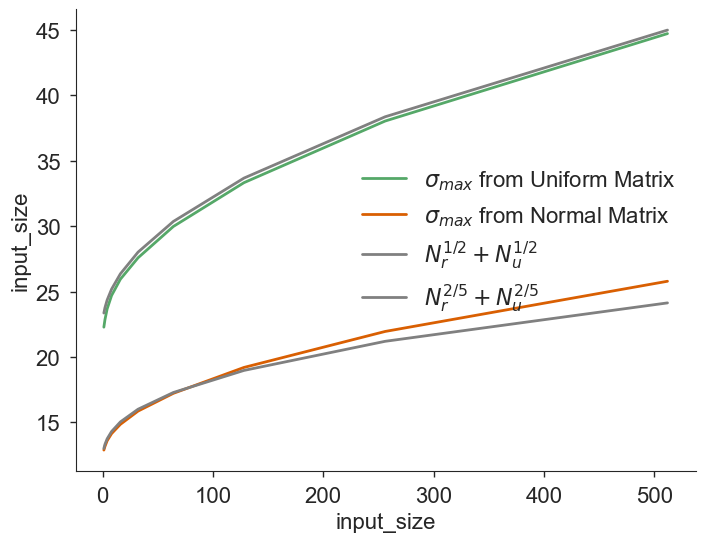

In [16]:
(ds.d_n.mean("sample")).plot(label=ds.d_n.label, linestyle='-')
(ds.d_u.mean("sample")).plot(label=ds.d_u.label, linestyle='-')
(np.sqrt(500)+np.sqrt(ds.input_size)).plot(
    label=r"$N_r^{1/2} + N_u^{1/2}$",
    color='gray')
((500**.4)+ds.input_size**.4).plot(
    label=r"$N_r^{2/5} + N_u^{2/5}$",
    color='gray')
plt.legend()

Observe:
- standard deviation grows like $N_u^{1/2}$ (normal) and $N_u^{2/5}$
- induced norm grows like $N_r^{1/2} + N_u^{1/2}$ (normal) and $N_r^{2/5} + N_u^{2/5}$

Is this useful? Unclear...

## How does this compare to using real data?

In [17]:
class LorenzInputVectorCalculator(InputVectorCalculator):
    
    input_sizes = np.array([5, 6, 8, 16, 32, 64, 128, 256, 512])
    def calc_input_vector(self):
        
        rs = np.random.RandomState(self.random_seed)
        ni = len(self.input_sizes)
        nor = np.zeros(shape=(ni, self.n_samples, self.n_reservoir))
        uni = nor.copy()
        d_u = np.zeros(shape=(ni, self.n_samples))
        d_n = d_u.copy()
        
        for i, n_input in enumerate(self.input_sizes):
            
            data = DataLorenz96(system_dimension=n_input)
            data.generate(n_steps=4000+self.n_samples)
            allU = data.values.T[-self.n_samples:, :]
            allU = (allU - allU.mean())/allU.std()
            
            for j,u in enumerate(allU):
                
                Wu = rs.uniform(low=-self.input_scale, high=self.input_scale, size=(self.n_reservoir,  n_input))
                Wn = rs.normal(scale=self.input_scale, size=(self.n_reservoir, n_input))
                
                d_u[i,j] = np.max(linalg.svdvals(Wu))
                d_n[i,j] = np.max(linalg.svdvals(Wn))
                
                nor[i, j, :] = Wn @ u
                uni[i, j, :] = Wu @ u
                
            print("Done with n_input = ", n_input)
            
            
        ds = self.pack_dataset(nor, uni, d_n, d_u)
        return ds

In [18]:
%%time
livc = LorenzInputVectorCalculator()
ds = livc.calc_input_vector()

Done with n_input =  5
Done with n_input =  6
Done with n_input =  8
Done with n_input =  16
Done with n_input =  32
Done with n_input =  64
Done with n_input =  128
Done with n_input =  256
Done with n_input =  512
CPU times: user 41.1 s, sys: 397 ms, total: 41.5 s
Wall time: 7.04 s


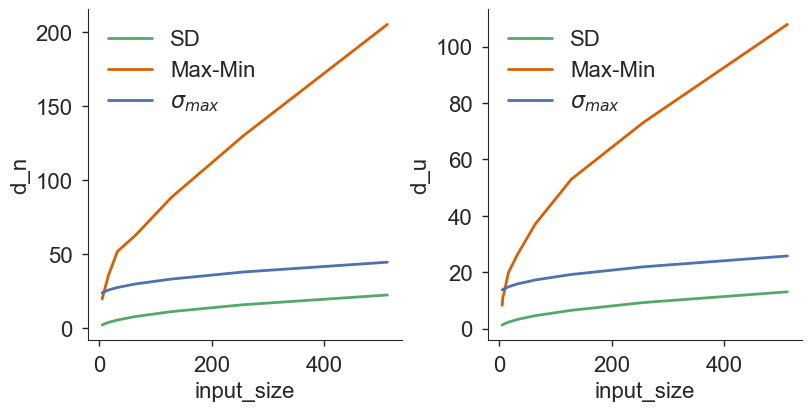

In [19]:
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

dims = ["reservoir", "sample"]
for key, ax in zip(
    ["normal", "uniform"],
    axs):
    p = ds[key].std(dims).plot(label="SD", ax=ax)
    color = p[0].get_color()
    rng = ds[key].max(dims) - ds[key].min(dims)
    rng.plot(label="Max-Min",  ax=ax)
    k = f"d_{key[0]}"
    ds[k].mean("sample").plot(label=r"$\sigma_{max}$", ax=ax)
    ax.legend()

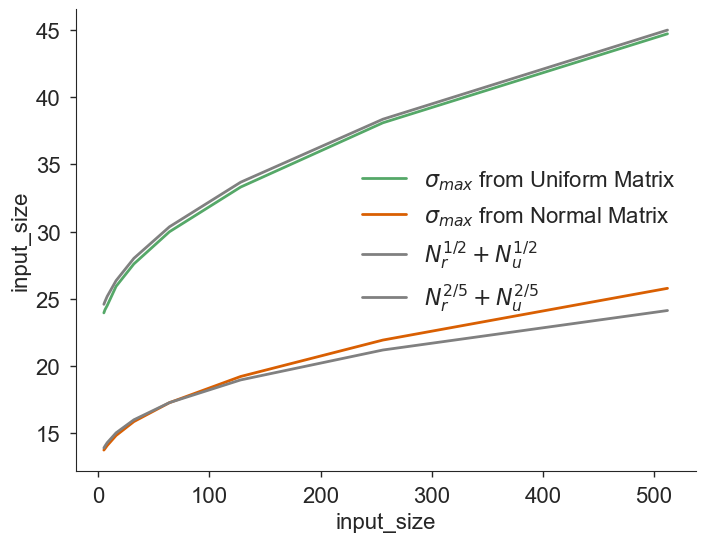

In [20]:
(ds.d_n.mean("sample")).plot(label=r'%s' % ds.d_n.label, linestyle='-')
(ds.d_u.mean("sample")).plot(label=ds.d_u.label, linestyle='-')
(np.sqrt(500)+np.sqrt(ds.input_size)).plot(
    label=r"$N_r^{1/2} + N_u^{1/2}$",
    color='gray')
((500**.4)+ds.input_size**.4).plot(
    label=r"$N_r^{2/5} + N_u^{2/5}$",
    color='gray')
plt.legend()

Who knows how real we can call the Lorenz96 system, but it sure does line up with
the "theoretical" results which use IID white noise.